In [1]:
import numpy as np
from scipy import constants
import scipy.integrate
import scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
from mpmath import hyp2f1, factorial, gamma
import functools
fsc = constants.alpha
aB_in_cm = constants.value('Bohr radius') * 1e2
Ry_in_erg = constants.value('Rydberg constant times hc in J') * 1.e7  # in ergs
kb = constants.k * 1e7
h = constants.value('Planck constant') * 1e7  # in ergs s
c = constants.c * 1.e2  # in cm/s
e_e = 4.80320451e-10  # in statcoulomb
m_e = constants.electron_mass * 1e3  # in g

In [2]:
def I(eta_i, eta_f, k_i, k_f, l):
    """something dumb (radial-dipole integral)

    Arguments:
    eta_i  : modified quantum number associated with initial energy
    eta_f  : modified quantum number associated with final energy
    k_i    : wavenumber associated with initial energy
    k_f    : wavenumber associated with final energy
    l      : azimuthal quantum number

    Returns:
    I_l    : some number.
    """
    temp1 = 1 / 4 * (4. * k_i * k_f / (k_i - k_f)**2)**(l + 1)
    temp2 = np.exp(np.pi / 2 * abs(eta_i - eta_f))
    temp3 = abs(gamma(l + 1 + 1j * eta_i) *
                gamma(l + 1 + 1j * eta_f)) / gamma(2. * l + 2)
    return temp1 * temp2 * temp3 * G(eta_i, eta_f, k_i, k_f, l)


def G(eta_i, eta_f, k_i, k_f, l):
    """something dumb helper"""
    temp1 = abs((k_f - k_i) / (k_f + k_i))**(1j * eta_i + 1j * eta_f)
    temp2 = hyp2f1(l + 1 - 1j * eta_f,
                   l + 1 - 1j * eta_i,
                   2. * l + 2,
                   -4. * k_i * k_f / (k_i - k_f)**2)

    return (temp1 * temp2).real

In [3]:
def gaunt_free_free(Z, beta, E):
    """calculate the Gaunt factor for free-free emission

    Arguments:
    Z    : ion charge, int
    beta : velocity of incident electron in units of c, float or array
    E    : energy of photon in units of Ha, float or array

    Returns:
    g_ff : gaunt factor for free-free emission"""

    eta_i = Z * fsc / beta
    k_i = Z / eta_i / aB_in_cm
    eta_f = Z * fsc / (beta**2 + 2 * E * fsc**2)**.5
    k_f = Z / eta_f / aB_in_cm

    I0 = I(eta_i, eta_f, k_i, k_f, 0)
    I1 = I(eta_i, eta_f, k_i, k_f, 1)

    out = 2 * 3**.5 / np.pi / eta_i / eta_f * I0
    out *= ((eta_i**2 + eta_f**2 + 2 * eta_i**2 * eta_f**2) * I0 - 2 *
            eta_i * eta_f * (1 + eta_i**2)**.5 * (1 + eta_f**2)**.5 * I1)

    return out.real

In [4]:
def free_free_emission_spectrum(Z, hnu, E):
    """calculate free-free spectrum

    Arguments:
    Z    : ion charge, int
    hnu  : energy of emitted photon, in Ha
    E    : electron final energy, in Ha"""
    if hnu >= E:
        return 0.
    g_ff = gaunt_free_free(Z, fsc * (2 * (E - hnu))**.5, hnu)
    return 64 * np.pi**2 / 3 / 3**.5 * Z**2 * fsc**3 / (2 * E)**.5 * g_ff

In [5]:
def free_free_thermal_spectrum(Z, T, E):
    """calculate free-free spectrum
    from an ensemble of electrons following a Maxwellian

    Arguments:
    Z    : ion charge, int
    T    : temperature of electrons, in Ha
    E    : energies of emitted photons, in Ha
    """
    out = np.zeros_like(E)
    for i, hnu in enumerate(E):
        out[i] = scipy.integrate.quad(
            lambda x: x**.5 * np.exp(-x / T) * free_free_emission_spectrum(Z, hnu, x), hnu, np.inf)[0]
        out[i] /= scipy.integrate.quad(lambda x: x**.5 *
                                       np.exp(-x / T), 0, np.inf)[0]
    return out

In [6]:
def emissivity_free_free(Z, T, nu):
    """calculate emissivity of free free emission

    Arguments:
    Z    : ion charge, int
    T    : temperature of electrons, in K
    nu   : frequency, in Hz
    """
    T_Ha = T * 3.16680853419133e-6
    hnu_Ha = nu * 1.519828500715e-16

    term = scipy.integrate.quad(lambda x: np.exp(-x / T_Ha) * gaunt_free_free(
        Z, fsc * (2 * (x - hnu_Ha))**.5, hnu_Ha), hnu_Ha, np.inf)[0]
    term /= scipy.integrate.quad(lambda x: x**.5 *
                                 np.exp(-x / T_Ha), 0, np.inf)[0]
    # the exponential is folded into the numerator

    prefactor = 2**5 * np.pi * Z**2 * e_e**6 / 3 / m_e / c**3
    temp2 = (2 * np.pi / 3 / kb / m_e / T)**.5
    return 1 / 2 / np.pi * prefactor * temp2 * term

In [7]:
def G_l(l, m, eta, rho):
    """G matrix element, radial-dipole integral"""
    gl = 0
    for i in range(2 * m + 1):
        gl += b_s(i, l, m, eta, rho) * rho**i
    return gl


@functools.lru_cache(maxsize=1024)
def b_s(s, l, m, eta, rho):
    """polynomial solution to matrix element G_l"""
    if s == 0:
        return 1
    if s == 1:
        return 2 * m * eta / l

    bsminus1 = b_s(s - 1, l, m, eta, rho)
    bsminus2 = b_s(s - 2, l, m, eta, rho)
    bs = -(1 / (s * (s + 2 * l - 1))) * (4 * eta * (s - 1 - m) *
                                         bsminus1 + (2 * m + 2. - s) * (2 * m + 2 * l + 1 - s) * bsminus2)
    return bs

In [8]:
def sigma_minus(n, l, E, Z):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l-1"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    nu = E / h
    if l == 0:
        return 0

    rho = eta / n
    GlA = G_l(l, -(l + 1 - n), eta, rho)
    GlB = G_l(l, -(l - 1 - n), eta, rho)

    prefactor = 2**(4 * l) / 3 * np.pi * e_e**2 / m_e / c / nu

    A = 1
    for l_i in range(1, l):
        A *= (l_i**2 + eta**2)
    B = l**2 * factorial(n + l) / factorial(2 * l + 1) / \
        factorial(2 * l - 1) / factorial(n - l - 1)
    C = np.exp(-4 * eta * np.arctan2(1, rho)) / (1 - np.exp(-2 * np.pi * eta))
    D = rho**(2 * l + 2) / (1 + rho**2)**(2 * n - 2)
    E = (GlA - (1 + rho**2)**(-2) * GlB)**2
    return prefactor * A * B * C * D * E


def sigma_plus(n, l, E, Z):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l+1"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    rho = eta / n
    nu = E / h
    GlA = G_l(l + 1, -(l + 1 - n), eta, rho)
    GlB = G_l(l + 1, -(l - n), eta, rho)

    prefactor = 2**(4 * l + 6) / 3 * np.pi * e_e**2 / m_e / c / nu

    A = 1
    for l_i in range(l + 1):
        A *= ((l_i + 1)**2 + eta**2)
    B = (l + 1)**2 * factorial(n + l) / (2 * l + 1) / factorial(2 * l + 1) / \
        factorial(2 * l + 2) / factorial(n - l - 1) / ((l + 1)**2 + eta**2)**2

    C = np.exp(-4 * eta * np.arctan2(1, rho)) / (1 - np.exp(-2 * np.pi * eta))
    D = rho**(2 * l + 4) * eta**2 / (1 + rho**2)**(2 * n)
    E = ((l + 1 - n) * GlA + (l + 1 + n) / (1 + rho**2) * GlB)**2
    return prefactor * A * B * C * D * E

In [9]:
@functools.lru_cache(maxsize=2048)
def sigma_bf_nl(n, l, nu, Z):
    """Bound-free cross section for absorption from (n, l) through
    dipole transition to E with angular momenta l+-1"""
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    return sigma_plus(n, l, h * nu, Z) + sigma_minus(n, l, h * nu, Z)


@functools.lru_cache(maxsize=2048)
def sigma_bf_n(n, Z, nu):
    """angular momentum-average Bound-free cross section from 
    n through dipole transition to E with """
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    sbf = 0
    for l in range(n):
        sbf += (2 * l + 1) * sigma_bf_nl(n, l, nu, Z)

    return sbf / n**2

In [10]:
def gaunt_bound_free_nl(nu, n, l, Z):
    """ratio of the cross section for bound-free absorption from 
    a bound state (n, l) to a free (continuum) state E with 
    unpolarized photon E_ph and the Kramers' semi-classical 
    bound-free cross section

    Arguments:
    n    : Principal quantum number
    l    : Azimuthal quantum number
    nu   : frequency of unpolarized photon
    Z    : ionization state

    Returns:
    g_bf : (n,l,nu) Gaunt factor for bound-free transitions
    """
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    sp = sigma_plus(n, l, h * nu, Z)
    sm = sigma_minus(n, l, h * nu, Z)
    sK = sigma_K(n, h * nu, Z)
    return (sp + sm) / sK


def sigma_K(n, E, Z):
    """Kramers' semi-classical bound-free cross section"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    rho = eta / n
    nu = E / h
    return 2.**4 / 3. / 3.**.5 * (e_e**2 / m_e / c / nu) / n * (rho**2 / (1 + rho**2))**2


def gaunt_bound_free_n(nu, n, Z):
    """ratio of the cross section for bound-free absorption from 
    a l-averaged bound states n to a free (continuum) state E with 
    unpolarized photon E_ph and the Kramers' semi-classical 
    bound-free cross section

    Arguments:
    n    : Principal quantum number
    nu   : frequency of unpolarized photon
    Z    : ionization state

    Returns:
    g_bf : (n, nu) Gaunt factor for bound-free transitions
    """
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    gbf = 0
    for l in range(n):
        gbf += (2 * l + 1) * gaunt_bound_free_nl(nu, n, l, Z)

    return gbf / n**2

In [11]:
def gamma_fb_n(n, Z, nu, T):
    """emission coefficient of single-shell bound-free transition for
    an ensemble of electrons at temperature T"""
    I_n = Z**2 * Ry_in_erg / n**2
    E = h * nu
    if E < I_n:
        return 0
    else:
        epsilon = h * nu / Z**2 / Ry_in_erg - 1 / n**2
        pre = 7.907e-18 * (n / Z**2) * (1 + n**2 * epsilon)**(-3)
        g = gaunt_bound_free_n(nu, n, Z)

    A = (2 / np.pi)**.5
    B = np.exp(I_n / kb / T) / \
        c**2 / (m_e * kb * T)**(3 / 2)
    C = 2 * n**2 * h * (h * nu)**3

    E = np.exp(-h * nu / kb / T)

    return A * B * C * pre * g * E

In [12]:
def emissivity_bound_free(n, Z, nu, T):
    """emission coefficient of shell-sum bound-free transition"""
    return sum([gamma_fb_n(i, Z, nu, T) for i in range(1, n)])

In [61]:
plot_ff = []
plot_bf = []
for nu in np.logspace(np.log10(3e13), np.log10(3e15), 400):
    plot_ff.append(nu * emissivity_free_free(1, 10000, nu))
    plot_bf.append(nu * emissivity_bound_free(20, 1, nu, 10000))
plot_ff = np.array(plot_ff)
plot_bf = np.array(plot_bf)

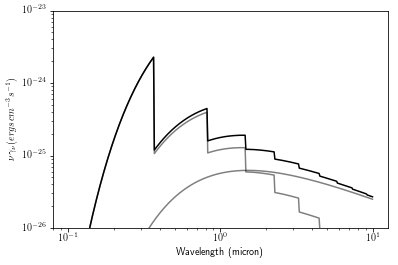

In [63]:
lam = c * 1e4 / np.logspace(np.log10(3e13), np.log10(3e15), 400)
plt.loglog(lam, plot_ff, alpha=.5, c='k')
plt.loglog(lam, plot_bf, alpha=.5, c='k')
plt.loglog(lam, plot_ff + plot_bf, c='k')

plt.ylim(1e-26, 1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (ergs \, cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')

In [13]:
nu_table = (10**14) * np.array([1e-26, 1.23, 2.47, 3.70,
                                4.93, 6.17, 7.40, 8.64, 9.87, 11.10, 12.34])  # 10^14 Hz
nug_nu = (10**-12) * np.array([0, 0.0373, 0.242,
                               0.679, 1.37, 2.33, 3.55, 5.01, 6.69, 8.59, 10.6])

g_nu = nug_nu / nu_table
# Interpolate points on table.
gnu_interp = scipy.interpolate.interp1d(nu_table, g_nu, kind='cubic')

In [14]:
alpha_eff = 0.838e-13  # cm^3 * s^-1
A_2 = 8.23  # s^-1
q_p = 2.51e-4 + 2.23e-4  # cm^3 * s^-1
q_e = 0.22e-4 + 0.35e-4  # cm^3 * s^-1
nu_12 = 2 * 1.234e15

In [15]:
def emissivity_2photon(nu_arr, n_p, n_e):
    """equation 4.29 in Osterbrock and Ferland 2nd edition"""
    gammas = []
    denom = 1 + ((n_p * q_p + n_e * q_p) / A_2)
    for nu in nu_arr:
        if nu <= nu_12 / 2:
            g_nu = gnu_interp(nu)
            gammas.append((alpha_eff) * g_nu / denom)
        elif nu > nu_12 / 2:
            if nu_12 - nu < (10**14 * 1E-26):
                gammas.append(0)
            else:
                g_nu2 = (nu / (nu_12 - nu)) * gnu_interp(nu_12 - nu)
                gammas.append((alpha_eff) * g_nu2 / denom)
    return gammas

In [67]:
nu_arr = np.logspace(np.log10(1.23e14), np.log10(2.467e15), 200)
gamma_nu_arr = emissivity_2photon(nu_arr, 0, 0)

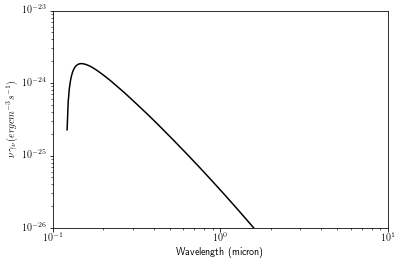

In [68]:
plt.loglog(c * 1e4 / nu_arr, nu_arr * gamma_nu_arr, c='k')
plt.ylabel(r'$\nu \gamma_{\nu} (erg cm^{-3}s^{-1})$')
plt.ylim(1e-26, 1e-23)
plt.xlim(0.1, 10)
plt.xlabel('Wavelength (micron)')

In [16]:
alpha_B = 2.6e-13  # cm^3 s^-1 for 10^4K only!

In [17]:
def nebular_continuum_emission(n, Z, nu, T, n_i, n_e, f_esc, N_LyC):
    """equation 3 in Ono 2010"""
    g_fb = emissivity_bound_free(n, Z, nu, T)
    g_ff = emissivity_free_free(Z, T, nu)
    g_2q = emissivity_2photon([nu], n_i, n_e)[0]
    return (g_fb + g_ff + g_2q) / alpha_B * (1 - f_esc) * N_LyC

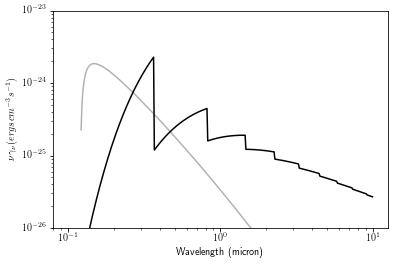

In [73]:
plt.loglog(lam, plot_ff + plot_bf, c='k')
plt.loglog(c * 1e4 / nu_arr, nu_arr * gamma_nu_arr, 'k', alpha=.3)
plt.ylim(1e-26, 1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (ergs \, cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')

In [18]:
def hbeta_line_luminosity(fesc, N_LyC):
    """equation 2 from Ono 2010"""
    return 4.78e-13 * (1 - fesc) * N_LyC


def compute(fluxhbeta):
    """calculate fluxes of Hydrogen line emission"""
    ratios = np.genfromtxt("ratios_10.dat")
    waves0, intensities, references = ratios[:, 0], ratios[:, 1], ratios[:, 2]
    nu0 = c * 1e8 / waves0
    intensities *= references
    intensities *= fluxhbeta

    return waves0 / 10000, intensities / nu0

In [19]:
def get_spectrum(n, Z, T, n_i, n_e, f_esc, N_LyC, waves):
    """
    Arguments:
    n    :   Maximum principal quantum number, int
    Z    :   ion charge, int
    T    :   temperature, K
    n_i  :   ion number density, cm^-3
    n_e  :   electron number density, cm^-3
    f_esc:   escape fraction, float
    N_LyC:   rate of Lyman Continuum photons, float
    waves:   wavelength array, in microns"""
    fluxhbeta = hbeta_line_luminosity(f_esc, N_LyC)
    wave0, lnu0 = compute(fluxhbeta)
    lnu0 = np.concatenate([lnu0, np.zeros(len(waves))])
    wavelengths = np.concatenate([wave0, waves])

    spec = [nebular_continuum_emission(
        n, Z, nu, T, n_i, n_e, f_esc, N_LyC) for nu in 3e14 / wavelengths]
    idx = np.argsort(wavelengths)
    out = (spec + lnu0)[idx]
    outwave = wavelengths[idx]
    return outwave, out

In [20]:
waves, specs = get_spectrum(20, 1, 10000, 1e4, 1e2,
                            0, 1e52, np.linspace(.1, 2.4, 1000))

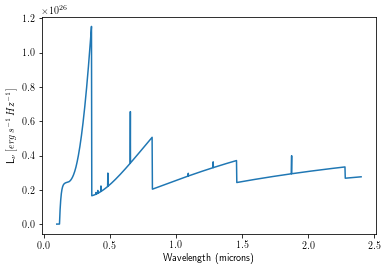

In [21]:
plt.plot(waves, specs)
plt.ylabel(r'L_{\nu}\, [erg\,s^{-1} \,Hz^{-1}]')
plt.xlabel('Wavelength (microns)')

In [41]:
np.savetxt('plot.txt', np.array([waves, specs]).T)